In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import h5py
import os
import re
from IPython.display import display, Audio
import pickle

In [31]:
df = pd.read_csv\
('/green-projects/project-sonyc_redhook/workspace/share/redhook-analysis/output/max_dataframe_cut.csv')

In [32]:
df.head()

,Unnamed: 0,start_timestamp,frame,actual_timestamp,area,probability
0,10,1573061868,648,1573061911,276490,0.988503
1,32,1573830164,72,1573830168,207648,0.995947
2,45,1573830164,1518,1573830265,294148,0.969995
3,64,1573830554,72,1573830558,103700,0.983073
4,70,1573830554,190,1573830566,122512,0.977682


In [2]:
def show_frame(video_file, frame_number):
    vid_obj = cv2.VideoCapture(video_file)
    vid_obj.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    res, frame = vid_obj.read()
    if res:
        cropped_frame = frame[200:850, 1100:1750]
        return cropped_frame
    else:
        return False

In [3]:
h5 = h5py.File\
('/green-projects/project-sonyc_redhook/workspace/share/redhook-analysis/output/max_img.hdf5', 'r')

In [4]:
list(h5.keys())

['max_img']

In [5]:
max_img = h5['max_img']

In [6]:
max_img.dtype

dtype([('start_timestamp', '<f8'), ('frame', '<i8'), ('actual_timestamp', '<f8'), ('area', '<f8'), ('probability', '<f8'), ('img', '<i8', (650, 650, 3))])

In [7]:
max_idx = max_img.shape[0]

In [9]:
target_timestamp = max_img[6000]['actual_timestamp']

In [ ]:
actual_timestamps = []
for idx in range(max_idx):
    actual_timestamps.append(max_img[idx]['actual_timestamp'])

In [ ]:
actual_timestamps = np.array(actual_timestamps)

In [ ]:
len(actual_timestamps)

In [31]:
#take the 0th element just in case there are multiple matches
row = max_img[actual_timestamps == target_timestamp][0]

In [60]:
np.where(actual_timestamps == target_timestamp)

(array([6000]),)

In [ ]:
#will eventually have list of wav files, named with the actual time, in an array
#then we will use a boolean mask to only annotate the files with corresponding audio
#will access the audio files using their timestamp, from the audio list (iloc? loc? boolean mask?)

In [17]:
# for folder in \
# os.listdir('/green-projects/project-sonyc_redhook/workspace/share/truck_audio/redhook_truck_audio/1s'):
#     count = 0
#     for file in os.listdir\
#     ('/green-projects/project-sonyc_redhook/workspace/share/truck_audio/redhook_truck_audio/1s/' + folder):
#         count += 1
#     print(folder)
#     print(count)
# start_timestamp = 1573584188
# end_timestamp = 1574577560
# for folder in \
#     os.listdir('/green-projects/project-sonyc_redhook/workspace/share/truck_audio/redhook_truck_audio/1s'):
#         for file in os.listdir\
#         ('/green-projects/project-sonyc_redhook/workspace/share/truck_audio/redhook_truck_audio/1s/' + folder):
#             audio_timestamp = int(file.split(".")[0])
#             if(start_timestamp <= audio_timestamp):
#                 start_ti

In [ ]:
def switch_color(img):
    """
    Switches the colors of an image from BGR format to RGB format.
    
    Parameters
    ----------
    img : ndarray
        An array representing an image, of the shape (x, x, 3). The array is in BGR format. 
        
    Returns
    -------
    switched_img : ndarray
        An array representing an image, of the shape (x, x, 3). The array is in RGB format.
    """
    #cv2 images are in bgr order, need to convert to rgb
    for i in range(len(img)):
        for j in range(len(img)):
            rgb_arr = img[:][i][j]
            #swapping r with b
            rgb_arr[0], rgb_arr[2] = rgb_arr[2], rgb_arr[0]
    return img

In [ ]:
def annotate_img(img_arr, start_timestamp, end_timestamp):
    """
    Displays an interface for annotating images to indicate whether there is a truck or not. The function
    then stores the annotations and the timestamp of the images in an array. The function loops 
    through the audio array and displays the corresponding image.
    
    Parameters
    ----------
    img_arr : array
        Array containing the image array inside. The image array should be in the 5th column of img_arr.
        
    start_timestamp : timestamp
        Timestamp to start the annotations.
        
    end_timestamp: timestamp
        Timestamp to end the annotations
    """
    with open('annotation_list.pickle', "rb") as f:
        annotation_list = pickle.load(f)
    
    #loop through the folders in redhook_truck_audio, get folder and file name
    for folder in \
    os.listdir('/green-projects/project-sonyc_redhook/workspace/share/truck_audio/redhook_truck_audio/1s'):
        for file in os.listdir\
        ('/green-projects/project-sonyc_redhook/workspace/share/truck_audio/redhook_truck_audio/1s/' + folder):
            audio_timestamp = int(file.split(".")[0])
            if(start_timestamp <= audio_timestamp) and (audio_timestamp <= end_timestamp):
                #use audio timestamp to get corresponding image 
                match_row = max_img[actual_timestamps == audio_timestamp][0]

                #display img
                plt.imshow(switch_color(match_row['img']))
                plt.show()

                #play 1 second clip of audio (for this simple indexing of the audio list to work, we need to make sure
                #the audio list corresponds with the masked list)
                print('Ten-second audio clip corresponding to the image')
                display(Audio(filename=\
                '/green-projects/project-sonyc_redhook/workspace/share/truck_audio/redhook_truck_audio/10s/' + \
                folder + '/' + file))

#                 clip = input("Press y if you would like to listen to the ten-second audio clip and n if not: ")

#                 if clip == 'y':
#                     print('Ten-second audio clip corresponding to the image')
#                     display(Audio(filename=\
#                     '/green-projects/project-sonyc_redhook/workspace/share/truck_audio/redhook_truck_audio/10s/' + \
#                     folder + '/' + file))

                #truck or no? not sure?
                annotation = ''
        
                while(annotation != 'y' and annotation != 'n' and annotation != 'm'):
                    annotation = input('Press y if the image and the audio show a truck, and n if not. '  + \
                                   'Press m if you are unsure: ')
                
                print('Annotation: ' + str(match_row['actual_timestamp']) + ', ' + annotation) 
                #add answer to annotation_list
                annotation_list.append((match_row['actual_timestamp'], annotation))

    with open('annotation_list.pickle', "wb") as f:
        pickle.dump(annotation_list, f)

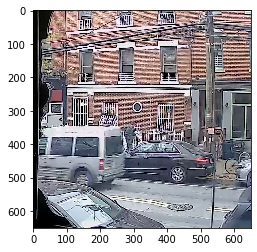

Ten-second audio clip corresponding to the image


In [ ]:
annotate_img(max_img, 1573581864, 1573585109)

In [19]:
with open('annotation_list.pickle', "rb") as f:
        print(len(pickle.load(f)))

486


In [26]:
with open('annotation_list.pickle', "rb") as f:
        for i in pickle.load(f):
            if i[0] == 1573585226:
                print('yes')